In [3]:
import os
import sys
sys.path.append('../../..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import feature_column as fc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import preprocessing
from sklearn.utils import shuffle
from tensorflow.keras.models import save_model,load_model

from utils.util import *
from utils.preprocessing import *
from utils.dataiter import Dataiter
from utils.evaluate import calculate_ctr, compute_rce, average_precision_score
from utils.target_encode import MTE_one_shot

import tensorflow.keras.backend as K
import core.config as conf

## Load Data

In [6]:
path = f'{conf.dataset_mini_path}/train'
train = read_data(path)

path = f'{conf.dataset_mini_path}/test'
test = read_data(path)

path = f'{conf.dataset_mini_path}/valid'
valid = read_data(path)

In [3]:
TARGET = 'comment'

## Preprocessing

In [4]:
def set_dataframe_types(df, train):
    df['id']   = np.arange( df.shape[0] )
    df['id']   = df['id'].astype(np.uint32)

    if train:
        df['reply_timestamp']   = df['reply_timestamp'].fillna(0)
        df['retweet_timestamp'] = df['retweet_timestamp'].fillna(0)
        df['comment_timestamp'] = df['comment_timestamp'].fillna(0)
        df['like_timestamp']    = df['like_timestamp'].fillna(0)

        df['reply_timestamp']   = df['reply_timestamp'].astype(np.uint32)
        df['retweet_timestamp'] = df['retweet_timestamp'].astype(np.uint32)
        df['comment_timestamp'] = df['comment_timestamp'].astype(np.uint32)
        df['like_timestamp']    = df['like_timestamp'].astype(np.uint32)

    df['tweet_timestamp']         = df['tweet_timestamp'].astype( np.uint32 )
    df['creator_follower_count']  = df['creator_follower_count'].astype( np.uint32 )
    df['creator_following_count'] = df['creator_following_count'].astype( np.uint32 )
    df['creator_account_creation']= df['creator_account_creation'].astype( np.uint32 )
    df['engager_follower_count']  = df['engager_follower_count'].astype( np.uint32 )
    df['engager_following_count'] = df['engager_following_count'].astype( np.uint32 )
    df['engager_account_creation']= df['engager_account_creation'].astype( np.uint32 )

    return df



def preprocess(df, target, train):
    df = set_dataframe_types(df, train)
    # df = df.set_index('id')
    # df.columns = conf.raw_features + conf.labels
    df = df.drop('text_tokens', axis=1)
    
    df = feature_extraction(df, features=conf.used_features, train=train) # extract 'used_features'
    cols = []

    return df

In [5]:
train = preprocess(train, TARGET, True)
valid = preprocess(valid, TARGET, True)
test = preprocess(test, TARGET, True)

In [6]:
train

,tweet_id,engager_following_count,engager_is_verified,domains,creator_following_count,media,creator_id,engager_follower_count,tweet_timestamp,language,...,creator_follower_count,creator_is_verified,reply,retweet,comment,like,dt_day,dt_dow,dt_hour,len_domains
0,6238B9E15E83B6D477394E9D80B3784E,1424,0,0,645,4,F09233A58769507FD4E6FD618BCFA5B6,595,1612883086,7F4FAB1EB12CD95EDCD9DB2A6634EFCE,...,560,0,0.0,0.0,0.0,0.0,9,1,15,0
1,731FB90C6CFEF1B71D322106573F71DB,416,0,0,3690,1,46BEEE566BB708F18075A60FDDAA8503,514,1612864776,E7F038DE3EAD397AEC9193686C911677,...,2591,0,0.0,0.0,0.0,0.0,9,1,9,0
2,89276E5272498E858EE8AF691EBF0951,311,0,0,146,0,83F59BF2E0778AC4078FA3F7B71F5960,376,1613661020,1F73BB863A39DB62B4A55B7E558DB1E8,...,174,0,0.0,0.0,0.0,1.0,18,3,15,0
3,502FDBC0EB4E7AB157D38262817716EB,16342,0,1,2124,0,C96110509F8B6256CE08A8AE85ED75DB,22461,1612751908,310ECD7D1E42216E3C1B31EFDDFC72A7,...,115852,1,0.0,0.0,0.0,0.0,8,0,2,1
4,CF1F523F7D4D4139E5FD3EBD72F27D5A,647,0,0,1101,0,2031F18622E7C6A30E702D33776BF2C1,388,1613060168,488B32D24BD4BB44172EB981C1BCA6FA,...,1208919,1,0.0,0.0,0.0,1.0,11,3,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4338901,EE63068E74D7E293457FDC2EA3527D65,1908,0,0,315,1,968FAF2F52AACA58C2B41CE5B13A811D,1785,1612670742,E7F038DE3EAD397AEC9193686C911677,...,248,0,0.0,0.0,0.0,1.0,7,6,4,0
4338902,F15B4615DA12447331AFEC90FA814B4D,713,0,0,937,0,54652625625729AE0E38196970594938,183,1612744473,488B32D24BD4BB44172EB981C1BCA6FA,...,114,0,0.0,0.0,0.0,0.0,8,0,0,0
4338903,DA947A6368CF4414BEA9172003A639FD,48,0,0,121,4,614E269F8E5D731946BDBC86E9DC4F4D,58,1612397867,B8B04128918BBF54E2E178BFF1ABA833,...,56033,0,0.0,0.0,0.0,1.0,4,3,0,0
4338904,730879D11261FA6700804AD49CCB59BB,135,0,0,368,4,5A5C7CCA69CDEBBD7E81C3797DE9DD7E,2,1612956173,488B32D24BD4BB44172EB981C1BCA6FA,...,6745,0,0.0,0.0,0.0,1.0,10,2,11,0


### pickle matching

#### language

In [7]:
pickle_path = conf.dict_path

In [8]:
user_main_language_path = pickle_path + "user_main_language.pkl"

if os.path.exists(user_main_language_path) :
    with open(user_main_language_path, 'rb') as f :
        user_main_language = pickle.load(f)

In [9]:
language_dict_path = pickle_path + "language_dict.pkl"

if os.path.exists(language_dict_path ) :
    with open(language_dict_path , 'rb') as f :
        language_dict = pickle.load(f)

In [10]:
train['language'] = train.apply(lambda x : language_dict[x['language']], axis = 1)
test['language'] = test.apply(lambda x : language_dict[x['language']], axis = 1)
valid['language'] = valid.apply(lambda x : language_dict[x['language']], axis = 1)

In [11]:
del language_dict

In [12]:
train['creator_main_language'] = train['creator_id'].map(user_main_language)
valid['creator_main_language'] = valid['creator_id'].map(user_main_language)
test['creator_main_language'] = test['creator_id'].map(user_main_language)

In [13]:
train['engager_main_language'] = train['engager_id'].map(user_main_language)
valid['engager_main_language'] = valid['engager_id'].map(user_main_language)
test['engager_main_language'] = test['engager_id'].map(user_main_language)

In [14]:
train['creator_and_engager_have_same_main_language'] = train.apply(lambda x : 1 if x['creator_main_language'] == x['engager_main_language'] else 0, axis = 1)
valid['creator_and_engager_have_same_main_language'] = valid.apply(lambda x : 1 if x['creator_main_language'] == x['engager_main_language'] else 0, axis = 1)
test['creator_and_engager_have_same_main_language'] = test.apply(lambda x : 1 if x['creator_main_language'] == x['engager_main_language'] else 0, axis = 1)

In [15]:
train['is_tweet_in_creator_main_language'] = train.apply(lambda x : 1 if x['creator_main_language'] == x['language'] else 0, axis = 1)
valid['is_tweet_in_creator_main_language'] = valid.apply(lambda x : 1 if x['creator_main_language'] == x['language'] else 0, axis = 1)
test['is_tweet_in_creator_main_language'] = test.apply(lambda x : 1 if x['creator_main_language'] == x['language'] else 0, axis = 1)

In [16]:
train['is_tweet_in_engager_main_language'] = train.apply(lambda x : 1 if x['engager_main_language'] == x['language'] else 0, axis = 1)
valid['is_tweet_in_engager_main_language'] = valid.apply(lambda x : 1 if x['engager_main_language'] == x['language'] else 0, axis = 1)
test['is_tweet_in_engager_main_language'] = test.apply(lambda x : 1 if x['engager_main_language'] == x['language'] else 0, axis = 1)

In [17]:
del user_main_language

In [18]:
train.head()

,tweet_id,engager_following_count,engager_is_verified,domains,creator_following_count,media,creator_id,engager_follower_count,tweet_timestamp,language,...,like,dt_day,dt_dow,dt_hour,len_domains,creator_main_language,engager_main_language,creator_and_engager_have_same_main_language,is_tweet_in_creator_main_language,is_tweet_in_engager_main_language
0,6238B9E15E83B6D477394E9D80B3784E,1424,0,0,645,4,F09233A58769507FD4E6FD618BCFA5B6,595,1612883086,10,...,0.0,9,1,15,0,9,35,0,0,0
1,731FB90C6CFEF1B71D322106573F71DB,416,0,0,3690,1,46BEEE566BB708F18075A60FDDAA8503,514,1612864776,1,...,0.0,9,1,9,0,1,1,1,1,1
2,89276E5272498E858EE8AF691EBF0951,311,0,0,146,0,83F59BF2E0778AC4078FA3F7B71F5960,376,1613661020,5,...,1.0,18,3,15,0,5,4,0,1,0
3,502FDBC0EB4E7AB157D38262817716EB,16342,0,1,2124,0,C96110509F8B6256CE08A8AE85ED75DB,22461,1612751908,12,...,0.0,8,0,2,1,12,1,0,1,0
4,CF1F523F7D4D4139E5FD3EBD72F27D5A,647,0,0,1101,0,2031F18622E7C6A30E702D33776BF2C1,388,1613060168,0,...,1.0,11,3,16,0,0,13,0,1,0


#### engagements

In [19]:
engagement_like_path = pickle_path + "engagement-like.pkl"

if os.path.exists(engagement_like_path ) :
    with open(engagement_like_path , 'rb') as f :
        engagement_like = pickle.load(f)

In [20]:
train['engager_feature_number_of_previous_like_engagement'] = train.apply(lambda x : engagement_like[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_like_engagement'] = valid.apply(lambda x : engagement_like[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_like_engagement'] = test.apply(lambda x : engagement_like[x['engager_id']], axis = 1)
del engagement_like

In [21]:
engagement_reply_path = pickle_path + "engagement-reply.pkl"

if os.path.exists(engagement_reply_path ) :
    with open(engagement_reply_path , 'rb') as f :
        engagement_reply = pickle.load(f)

In [22]:
train['engager_feature_number_of_previous_reply_engagement'] = train.apply(lambda x : engagement_reply[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_reply_engagement'] = valid.apply(lambda x : engagement_reply[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_reply_engagement'] = test.apply(lambda x : engagement_reply[x['engager_id']], axis = 1)
del engagement_reply

In [23]:
engagement_retweet_path = pickle_path + "engagement-retweet.pkl"

if os.path.exists(engagement_retweet_path ) :
    with open(engagement_retweet_path , 'rb') as f :
        engagement_retweet = pickle.load(f)

In [24]:
train['engager_feature_number_of_previous_retweet_engagement'] = train.apply(lambda x : engagement_retweet[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_retweet_engagement'] = valid.apply(lambda x : engagement_retweet[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_retweet_engagement'] = test.apply(lambda x : engagement_retweet[x['engager_id']], axis = 1)
del engagement_retweet

In [25]:
engagement_comment_path = pickle_path + "engagement-comment.pkl"

if os.path.exists(engagement_comment_path ) :
    with open(engagement_comment_path , 'rb') as f :
        engagement_comment = pickle.load(f)

In [26]:
train['engager_feature_number_of_previous_comment_engagement'] = train.apply(lambda x : engagement_comment[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_comment_engagement'] = valid.apply(lambda x : engagement_comment[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_comment_engagement'] = test.apply(lambda x : engagement_comment[x['engager_id']], axis = 1)
del engagement_comment

In [27]:
train['number_of_engagements_positive'] = train.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] + x['engager_feature_number_of_previous_retweet_engagement'] + x['engager_feature_number_of_previous_reply_engagement'] + x['engager_feature_number_of_previous_comment_engagement'], axis = 1)
valid['number_of_engagements_positive'] = valid.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] + x['engager_feature_number_of_previous_retweet_engagement'] + x['engager_feature_number_of_previous_reply_engagement'] + x['engager_feature_number_of_previous_comment_engagement'], axis = 1)
test['number_of_engagements_positive'] = test.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] + x['engager_feature_number_of_previous_retweet_engagement'] + x['engager_feature_number_of_previous_reply_engagement'] + x['engager_feature_number_of_previous_comment_engagement'], axis = 1)

In [28]:
train = train.drop('engager_feature_number_of_previous_reply_engagement', axis = 1)
train = train.drop('engager_feature_number_of_previous_like_engagement', axis = 1)
train = train.drop('engager_feature_number_of_previous_retweet_engagement', axis = 1)
# train = train.drop('engager_feature_number_of_previous_comment_engagement', axis = 1)

In [29]:
valid = valid.drop('engager_feature_number_of_previous_reply_engagement', axis = 1)
valid = valid.drop('engager_feature_number_of_previous_like_engagement', axis = 1)
valid = valid.drop('engager_feature_number_of_previous_retweet_engagement', axis = 1)
# valid = valid.drop('engager_feature_number_of_previous_comment_engagement', axis = 1)

In [30]:
test = test.drop('engager_feature_number_of_previous_reply_engagement', axis = 1)
test = test.drop('engager_feature_number_of_previous_like_engagement', axis = 1)
test = test.drop('engager_feature_number_of_previous_retweet_engagement', axis = 1)
# test = test.drop('engager_feature_number_of_previous_comment_engagement', axis = 1)

In [31]:
train[f'number_of_engagements_ratio_{TARGET}'] = train.apply(lambda x : x[f'engager_feature_number_of_previous_{TARGET}_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
valid[f'number_of_engagements_ratio_{TARGET}'] = valid.apply(lambda x : x[f'engager_feature_number_of_previous_{TARGET}_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
test[f'number_of_engagements_ratio_{TARGET}'] = test.apply(lambda x : x[f'engager_feature_number_of_previous_{TARGET}_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)

## Sampling

In [32]:
# df_negative = df_negative.sample(n = len(df_positive), random_state=777)

In [33]:
# train = pd.concat([df_positive, df_negative])

In [34]:
# train  = train.sample(frac = 1)

In [35]:
# del df_positive
# del df_negative

## Split

In [36]:
label_names = ['reply', 'retweet', 'comment', 'like']
DONT_USE = ['tweet_timestamp','creator_account_creation','engager_account_creation','engage_time',
            'creator_account_creation', 'engager_account_creation',
            'fold','tweet_id', 
            'tr','dt_day','','',
            'engager_id','creator_id','engager_is_verified',
            'elapsed_time',
            'links','domains','hashtags0','hashtags1',
            'hashtags','tweet_hash','dt_second','id',
            'tw_hash0',
            'tw_hash1',
            'tw_rt_uhash',
            'same_language', 'nan_language','language',
            'tw_hash', 'tw_freq_hash','tw_first_word', 'tw_second_word', 'tw_last_word', 'tw_llast_word',
            'ypred','creator_count_combined','creator_user_fer_count_delta_time','creator_user_fing_count_delta_time','creator_user_fering_count_delta_time','creator_user_fing_count_mode','creator_user_fer_count_mode','creator_user_fering_count_mode'
           ]
DONT_USE += label_names
DONT_USE += conf.labels

In [37]:
RMV = [c for c in DONT_USE if c in train.columns]

In [38]:
y_train = train[TARGET]
X_train = train.drop(RMV, axis=1)

In [39]:
del train

In [40]:
y_valid = valid[TARGET]
X_valid = valid.drop(RMV, axis=1)
del valid

In [41]:
y_test = test[TARGET]
X_test = test.drop(RMV, axis=1)
del test

## Scaling

In [42]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_valid.reset_index(drop=True)

In [50]:
scaling_columns = ['creator_following_count', 'creator_follower_count', 'engager_follower_count', 'engager_following_count', f'engager_feature_number_of_previous_{TARGET}_engagement', 'number_of_engagements_positive', 'dt_dow', 'dt_hour', 'len_domains']

In [51]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_train[scaling_columns])

StandardScaler()

In [52]:
ss = standard_scaler.transform(X_train[scaling_columns])
X_train[scaling_columns] = pd.DataFrame(ss, columns = scaling_columns)

In [53]:
ss = standard_scaler.transform(X_valid[scaling_columns])
X_valid[scaling_columns] = pd.DataFrame(ss, columns = scaling_columns)

In [54]:
ss = standard_scaler.transform(X_test[scaling_columns])
X_test[scaling_columns] = pd.DataFrame(ss, columns = scaling_columns)

In [55]:
X_train = X_train.fillna(X_train.mean())
X_valid = X_valid.fillna(X_valid.mean())
X_test = X_test.fillna(X_test.mean())

In [56]:
X_train

,engager_following_count,creator_following_count,media,engager_follower_count,tweet_type,creator_follows_engager,creator_follower_count,creator_is_verified,dt_dow,dt_hour,len_domains,creator_main_language,engager_main_language,creator_and_engager_have_same_main_language,is_tweet_in_creator_main_language,is_tweet_in_engager_main_language,engager_feature_number_of_previous_comment_engagement,number_of_engagements_positive,number_of_engagements_ratio_comment
0,0.431057,-0.091460,4,-0.021594,3,0,-0.168341,0,-1.022717,0.443646,-0.339718,9,35,0,0,0,-0.161077,0.509384,0.0
1,-0.176057,0.000084,1,-0.030005,0,1,-0.167882,0,-1.022717,-0.443985,-0.339718,1,1,1,1,1,-0.161077,-0.394315,0.0
2,-0.239298,-0.106462,0,-0.044336,3,1,-0.168428,0,0.017867,0.443646,-0.339718,5,4,0,1,0,-0.161077,-0.376973,0.0
3,9.416108,-0.046996,0,2.249159,3,1,-0.142296,1,-1.543009,-1.479555,2.560201,12,1,0,1,0,-0.161077,0.536360,0.0
4,-0.036927,-0.077751,0,-0.043090,3,0,0.104632,1,0.017867,0.591585,-0.339718,0,13,0,1,0,-0.161077,-0.332655,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4338901,0.722569,-0.101381,1,0.101986,3,0,-0.168411,0,1.578743,-1.183678,-0.339718,1,1,1,1,1,-0.161077,-0.326874,0.0
4338902,0.002825,-0.082681,0,-0.064379,0,1,-0.168441,0,-1.543009,-1.775432,-0.339718,0,0,1,1,1,-0.161077,-0.267142,0.0
4338903,-0.397702,-0.107213,4,-0.077360,3,0,-0.155809,0,0.017867,-1.775432,-0.339718,17,3,0,0,1,-0.161077,-0.398168,0.0
4338904,-0.345302,-0.099788,4,-0.083176,3,0,-0.166943,0,-0.502425,-0.148108,-0.339718,0,0,1,1,1,-0.161077,-0.392388,0.0


## Modeling

In [57]:
model = Sequential([
    Dense(16, activation = 'relu', input_dim = X_train.shape[1]),
    Dense(8, activation = 'relu'),
    Dense(4, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [58]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy', # softmax : sparse_categorical_crossentropy, sigmoid : binary_crossentropy
    metrics=['binary_crossentropy']) # sigmoid :binary_crossentropy

In [59]:
result = model.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_valid, y_valid),
    epochs=5,
    batch_size=32
)

Epoch 1/5
135591/135591 [==============================] - 60s 442us/step - loss: 0.0331 - binary_crossentropy: 0.0331 - val_loss: 0.0316 - val_binary_crossentropy: 0.0316
Epoch 2/5
135591/135591 [==============================] - 60s 440us/step - loss: 0.0318 - binary_crossentropy: 0.0318 - val_loss: 0.0312 - val_binary_crossentropy: 0.0312
Epoch 3/5
135591/135591 [==============================] - 60s 440us/step - loss: 0.0317 - binary_crossentropy: 0.0317 - val_loss: 0.0311 - val_binary_crossentropy: 0.0311
Epoch 4/5
135591/135591 [==============================] - 60s 440us/step - loss: 0.0316 - binary_crossentropy: 0.0316 - val_loss: 0.0313 - val_binary_crossentropy: 0.0313
Epoch 5/5
135591/135591 [==============================] - 60s 441us/step - loss: 0.0316 - binary_crossentropy: 0.0316 - val_loss: 0.0311 - val_binary_crossentropy: 0.0311


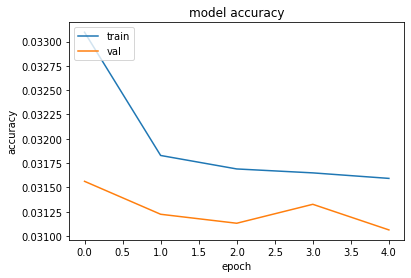

In [60]:
plt.plot(result.history['binary_crossentropy'])
plt.plot(result.history['val_binary_crossentropy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [57]:
model.evaluate(X_test, y_test)

27327/27327 [==============================] - 8s 291us/step - loss: 0.5944 - binary_crossentropy: 0.5944


[0.5944270491600037, 0.5944270491600037]

In [66]:
model.save(f'./saved_model/ffnn_{TARGET}')

INFO:tensorflow:Assets written to: ./saved_model/ffnn_comment/assets


## Predict

In [67]:
model = tf.keras.models.load_model(f'./saved_model/ffnn_{TARGET}')

In [61]:
pred = model.predict(X_test)

In [64]:
rce = compute_rce(pred, y_test)
rce

25.39087406295415

In [65]:
average_precision_score(y_test, pred)

0.13562722217312573